In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import sys

for mod in ["sutton_functions"]:
    if mod in sys.modules:
            del sys.modules[mod]
            
from sutton_functions import *

CPU times: user 928 ms, sys: 1.79 s, total: 2.72 s
Wall time: 397 ms


In [2]:
# Main script
# Constants
k = 0.4  # von Karman constant

# Flow conditions
ustar = 0.25  # Friction velocity (m/s)
zom = 0.1    # Momentum roughness length (m)

# Water vapor boundary conditions (gm/m3)
Qs = 11      # Surface wv concentration
Qa = 8       # Upwind background atmospheric wv concentration

# Domain specification
Lx = 5000
Hmax = 150

Lx=500 
Hmax=50

xmin = 0
xmax = Lx
zmin = zom
zmax = Hmax

# Generate grid
nx = 500
nz = 500
dx = (xmax - xmin) / nx
dz = (zmax - zmin) / nz
z = np.arange(zmin + dz, zmax + dz, dz)
print (z.shape, dz, zmin, zmax)
x = np.arange(xmin, xmax + dx, dx)

# Generate the mean velocity from log-law
U = (ustar / k) * np.log(z / zom)

# U = (ustar / k) * (z / zom)**(.2)

# Specify upwind wv concentration (as background)
Qup = np.ones(nz) * Qa

# Setup coefficients for implicit scheme
A = k * z * ustar
B = 1.0 / U
C = our_central_difference(A, dz)

# Upwind wv concentrations and fluxes
Q1 = Qup
Q = np.zeros((nx + 1, nz))
Q[0, :] = Q1
FluxQ = np.zeros((nx + 1, nz))


# Begin downwind calculations by marching along x
for i in range(nx):
    Q2, Fq = integrate_H2O_implicit(nx, nz, dx, dz, A, B, C, Q1, Qs, Qa)
    
    Q[i + 1, :] = Q2
    FluxQ[i + 1, :] = Fq
    Q1 = Q2

FluxQ[FluxQ < 1e-10] = 0    


(500,) 0.0998 0.1 50


Text(0, 0.5, '$z$')

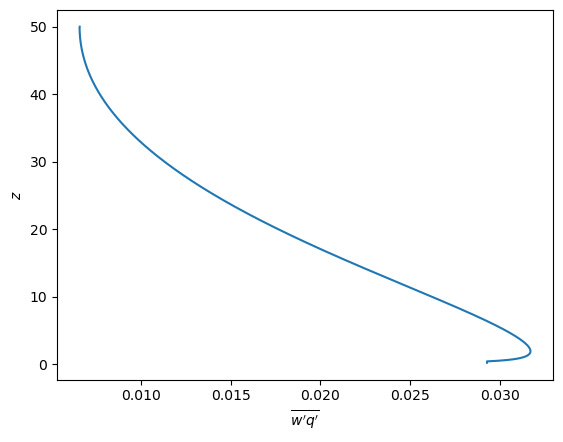

In [5]:
plt.plot((FluxQ[-1,:500]), z[:500])

plt.xlabel(r"$\overline{w'q'}$")
plt.ylabel(r"$z$")


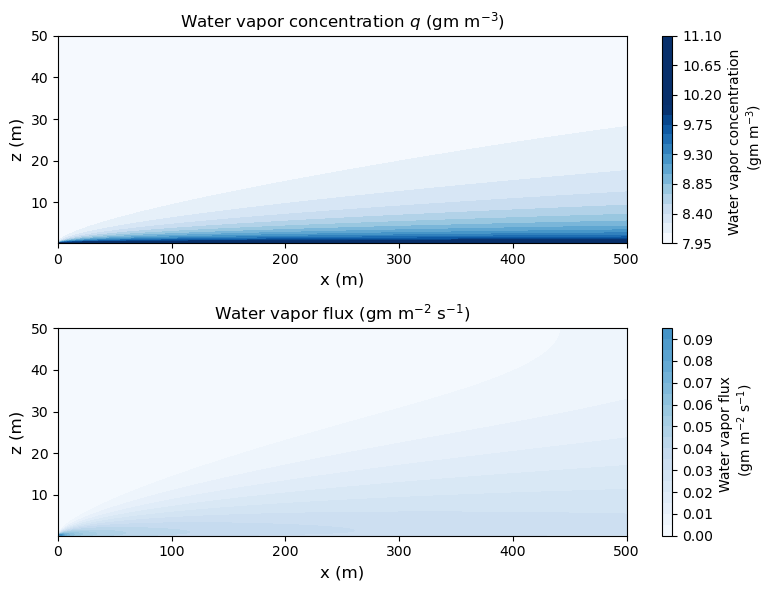

In [6]:
# Plot water vapor concentration and vertical flux
plt.figure(figsize = (8, 6))

# Normalized concentration (if needed)
# Qd = (Q - Qa) / (Qs - Qa)
plt.subplot(2, 1, 1)
plt.contourf(x, z, (Q.T), 25, cmap='Blues',  vmax = 10, vmin = 8)
plt.colorbar(label='Water vapor concentration \n (gm m$^{-3}$)')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ (gm m$^{-3}$)', fontsize=12)

plt.subplot(2, 1, 2)
plt.contourf(x, z, FluxQ.T,  20, cmap='Blues', vmax = 0.15)
plt.colorbar(label='Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)') 
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)

plt.tight_layout()
plt.show()


In [7]:
import pandas as pd

(0.0, 0.09811644413943972)

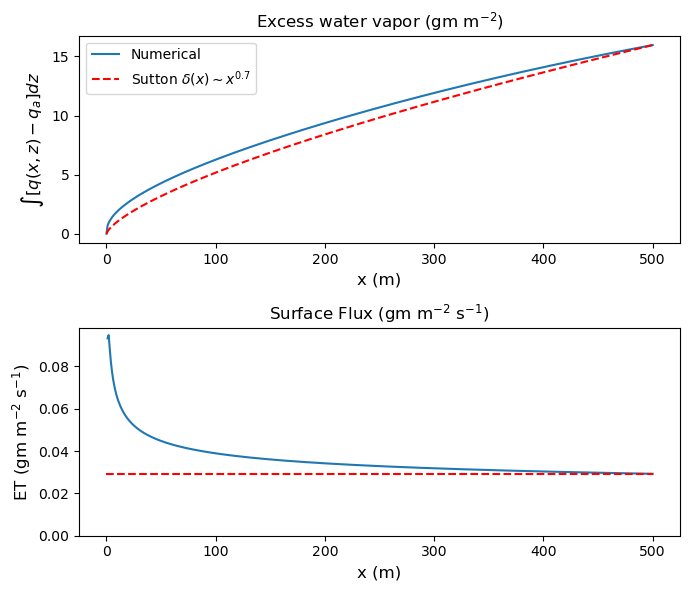

In [8]:
# Plot excess water vapor and surface flux
plt.figure(figsize = (7, 6))

QQ = np.sum(Q - Qa, axis=1) * dz

plt.subplot(2, 1, 1)
plt.plot(x, QQ, '-')
plt.plot(x, np.max(QQ) * (x / Lx) ** 0.7, 'r--')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel(r'$\int [q(x,z) - q_a]dz$', fontsize=12, fontweight='normal')
plt.title('Excess water vapor (gm m$^{-2}$)', fontsize=12)
plt.legend(['Numerical', 'Sutton $\delta(x) \sim x^{0.7}$'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(x[1:], FluxQ[1:, 0], '-')
plt.plot(x, np.ones(nx + 1) * FluxQ[nx, 0], 'r--')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('ET (gm m$^{-2}$ s$^{-1}$)', fontsize=12, fontweight='normal')
plt.title('Surface Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
plt.tight_layout()
plt.ylim(0, )

In [11]:
!open .

0.22276709258363692

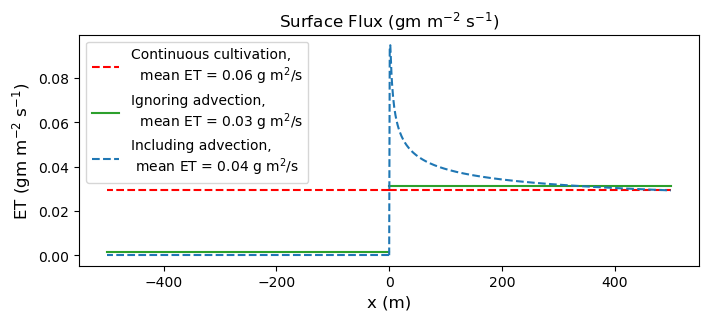

In [9]:

plt.figure(figsize = (8, 3))

QQ = np.sum(Q - Qa, axis=1) * dz


plt.plot(x, np.ones(nx + 1) * FluxQ[nx, 0], 'r--',  label = "Continuous cultivation, \n  mean ET = {0:.2f} g m$^2$/s".format(
    FluxQ[nx:,  0].sum()*2*dx))
plt.plot(-x, np.ones(nx + 1) * FluxQ[nx, 0], 'r--')


plt.plot(x, np.ones(nx + 1) * FluxQ[nx, 0]+0.002, 'C2',  label = "Ignoring advection, \n  mean ET = {0:.2f} g m$^2$/s".format(
    FluxQ[nx:,  0].sum()*dx))
plt.plot(-x, np.zeros(nx + 1) * FluxQ[nx, 0]+0.0015, 'C2')


plt.plot(x[:], FluxQ[:, 0], 'C0--', label = "Including advection,  \n mean ET = {0:.2f} g m$^2$/s".format(
    FluxQ[:, 0].sum()*dx/nx))
plt.plot(- x[1:], 0*FluxQ[1:, 0], 'C0--')

plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('ET (gm m$^{-2}$ s$^{-1}$)', fontsize=12, fontweight='normal')
plt.title('Surface Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
plt.legend(loc = 'upper left')

(FluxQ[:, 0].sum()*dx/nx - FluxQ[nx:,  0].sum()*dx)/(FluxQ[nx:,  0].sum()*dx)

Text(0.5, 1.0, 'y=(Q-Q_a)/(Q_s-Q_a)')

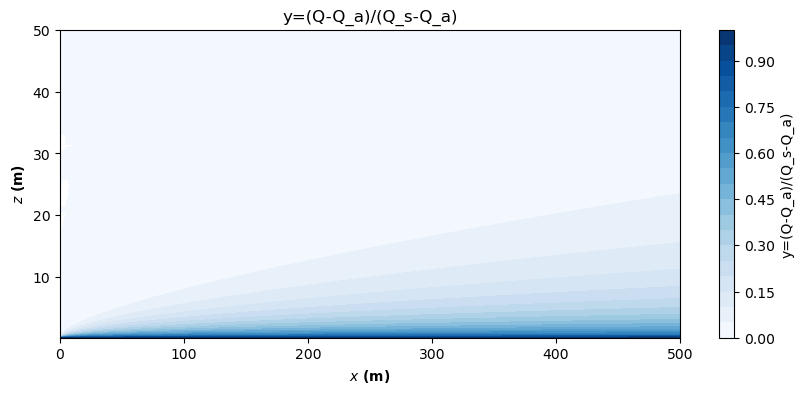

In [10]:

# Normalized concentration
Qd = (Q - Qa) / (Qs - Qa)

plt.figure(3, figsize = (10,4))
plt.clf()
plt.contourf(x, z, Qd.T, 20, vmax =1, cmap='Blues')
plt.xlabel(r'$\it{x}$ (m)', fontweight='bold', fontsize=10)
plt.ylabel(r'$\it{z}$ (m)', fontweight='bold', fontsize=10)
plt.colorbar(label='y=(Q-Q_a)/(Q_s-Q_a)')
plt.title('y=(Q-Q_a)/(Q_s-Q_a)')
